<a href="https://colab.research.google.com/github/JoaoVitorSantiagoNogueira/deepLearning2023/blob/main/T3/DL_Task3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Task 3

Test different auto-encoder architectures for fair comparison the data size in the bottleneck should be 1/4 of the original image's height, width and number of channels.

## Theory

### references:

[1] https://www.geeksforgeeks.org/implementing-an-autoencoder-in-pytorch/

[2] https://www.v7labs.com/blog/autoencoders-guide

[3] https://pyimagesearch.com/2020/02/24/denoising-autoencoders-with-keras-tensorflow-and-deep-learning/

[4] https://discuss.pytorch.org/t/where-is-the-noise-layer-in-pytorch/2887/4

## Code

### Intialization

In [1]:
#create and train NN
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F


# visualize dataset
import matplotlib.pyplot as plt

# download and make dataset
import requests
import zipfile
from pathlib import Path
from glob import glob
import os
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from PIL import Image

In [2]:
print(torch.cuda.is_available())
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

True


### model definition

auto encoder used on a [previous work](https://github.com/JoaoVitorSantiagoNogueira/tcc-testes), removing the middle layers as no processing needs to be done. This will serve as our baseline. Steal model concatenation from task2

we *are not* using skip conections, since we are just reconstructing images and skip connections would allow us to cheat by skipping the network entirely.   

#### Basic Auto Encoder (w/ convolutional layers)

In [3]:
class BaseNetwork(nn.Module):
    def __init__(self):
        super(BaseNetwork, self).__init__()

    def init_weights(self, init_type='normal', gain=0.02):
        '''
        initialize network's weights
        init_type: normal | xavier | kaiming | orthogonal
        https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix/blob/9451e70673400885567d08a9e97ade2524c700d0/models/networks.py#L39
        '''

        def init_func(m):
            classname = m.__class__.__name__
            if hasattr(m, 'weight') and (classname.find('Conv') != -1 or classname.find('Linear') != -1):
                if init_type == 'normal':
                    nn.init.normal_(m.weight.data, 0.0, gain)
                elif init_type == 'xavier':
                    nn.init.xavier_normal_(m.weight.data, gain=gain)
                elif init_type == 'kaiming':
                    nn.init.kaiming_normal_(m.weight.data, a=0, mode='fan_in')
                elif init_type == 'orthogonal':
                    nn.init.orthogonal_(m.weight.data, gain=gain)

                if hasattr(m, 'bias') and m.bias is not None:
                    nn.init.constant_(m.bias.data, 0.0)

            elif classname.find('BatchNorm2d') != -1:
                nn.init.normal_(m.weight.data, 1.0, gain)
                nn.init.constant_(m.bias.data, 0.0)

        self.apply(init_func)


In [4]:
class AutoEncoder(BaseNetwork):
    def __init__(self, residual_blocks=8, init_weights=True):
        super(AutoEncoder, self).__init__()


        ### halves height and width, doubles the number of channels, size =   Hi * Wi
        self.encoder1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=6, kernel_size=4, stride=2, padding=1),
            nn.InstanceNorm2d(2, track_running_stats=False),
            nn.ReLU(True),
        )
        ### halves height and width, keeps the number of channels, size = 1/2 Hi * Wi
        self.encoder2 = nn.Sequential(
            nn.Conv2d(in_channels=6, out_channels=6, kernel_size=4, stride=2, padding=1),
            nn.InstanceNorm2d(2, track_running_stats=False),
            nn.ReLU(True),
        )
        ### halves height and width, keeps the number of channels, size = 1/4 * Hi * Wi
        self.encoder3 = nn.Sequential(
            nn.Conv2d(in_channels=6, out_channels=6, kernel_size=4, stride=2, padding=1),
            nn.InstanceNorm2d(2, track_running_stats=False),
            nn.ReLU(True),
        )


        ### doubles height and width, keeps number of channels, size = Hi * Wi
        self.decoder1 = nn.Sequential(
            #nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=4, stride=2, padding=1),
            #changes to avoid chckered patterns, parameters chosen to keep the same dimensions
            nn.Upsample(scale_factor= 4, mode='bilinear'),
            nn.ReflectionPad2d(1),
            nn.Conv2d(in_channels=6, out_channels=6, kernel_size=4, stride=2, padding=0),
            # [batch_size, 128, 128, 128]
            nn.InstanceNorm2d(2, track_running_stats=False),
            nn.ReLU(True),
        )

        ### doubles height and width the same, keeps the number of channels, size = 2 * Hi * Wi
        self.decoder2 = nn.Sequential(
            #nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=4, stride=2, padding=1),
            nn.Upsample(scale_factor= 4, mode='bilinear'),
            nn.ReflectionPad2d(1),
            nn.Conv2d(in_channels=6, out_channels=6, kernel_size=4, stride=2, padding=0),
            # [batch_size, 64, 256, 256]
            nn.InstanceNorm2d(2, track_running_stats=False),
            nn.ReLU(True),
        )

        ### keeps height and width the same, halves the number of channels, size = Hi * Wi
        self.decoder3 = nn.Sequential(
            nn.Upsample(scale_factor= 4, mode='bilinear'),
            nn.ReflectionPad2d(1),
            nn.Conv2d(in_channels=6, out_channels=3, kernel_size=4, stride=2, padding=0),
        )

        if init_weights:
            self.init_weights()

    def forward(self, x):
        down1 = self.encoder1(x)
        down2 = self.encoder2(down1)
        down3 = self.encoder3(down2)
        ## now go up
        up1 = self.decoder1(down3)
        up2 = self.decoder2(up1)
        up3 = self.decoder3(up2)

        return up3

        x = (torch.tanh(up3) + 1) / 2

        return x

sanity check

In [5]:
def sanity_check(model):
  input_image = torch.rand((2, 3, 256, 256))
  check_model = model

  #Total parameters and trainable parameters.
  total_params = sum(p.numel() for p in check_model.parameters())
  print(f"{total_params:,} total parameters.")
  total_trainable_params = sum(
      p.numel() for p in check_model.parameters() if p.requires_grad)
  print(f"{total_trainable_params:,} training parameters.")

  with torch.no_grad():
    outputs = check_model(input_image)
    print(outputs.shape)

  f, axarr = plt.subplots(1,2)

  #the 0th image of the 'batch', changing channels to match the right order.
  axarr[0].imshow(input_image[0].permute(1, 2, 0))

  axarr[1].imshow(outputs[0].detach().permute(1, 2, 0), cmap="gray")


2,913 total parameters.
2,913 training parameters.
torch.Size([2, 3, 256, 256])


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/instancenorm.py:80: UserWarning: input's size at dim=1 does not match num_features. You can silence this warning by not passing in num_features, which is not used because affine=False
  warnings.warn(f"input's size at dim={feature_dim} does not match num_features. "


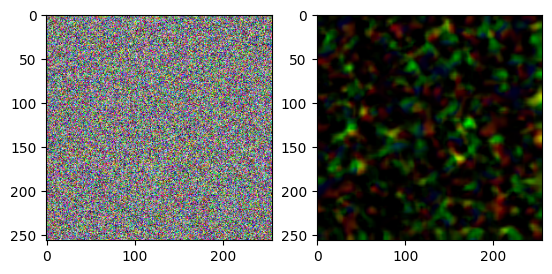

In [6]:
sanity_check(AutoEncoder())

#### Basic Auto Encoder (Fully conected layers)

In [7]:
class AutoEncoderFC(torch.nn.Module):
    def __init__(self):
        super().__init__()


        self.encoder = torch.nn.Sequential(
            torch.nn.Linear(256 * 256 * 3,  256),
            torch.nn.ReLU(),
            torch.nn.Linear(256, 128),
        )

        self.decoder = torch.nn.Sequential(
            torch.nn.Linear(128, 256),
            torch.nn.ReLU(),
            torch.nn.Linear(256, 256 * 256 * 3),
            torch.nn.Sigmoid()
        )

    def forward(self, x):
        reshaped = x.reshape(-1, 3* 256* 256)
        encoded = self.encoder(reshaped)
        decoded = self.decoder(encoded)
        x = decoded.view_as(x)
        return x

100,926,080 total parameters.
100,926,080 training parameters.
torch.Size([2, 3, 256, 256])


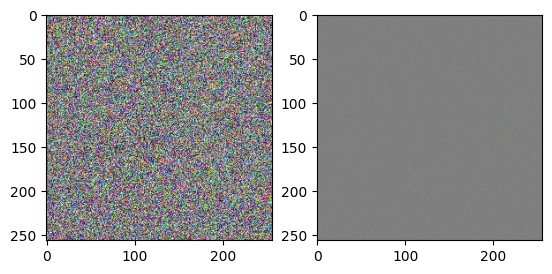

In [8]:
sanity_check(AutoEncoderFC())

#### Basic Auto Encoder (w/ convolutional layers and NOISE)

In [106]:
class GaussianNoise(nn.Module):
    """Gaussian noise regularizer.

    Args:
        sigma (float, optional): relative standard deviation used to generate the
            noise. Relative means that it will be multiplied by the magnitude of
            the value your are adding the noise to. This means that sigma can be
            the same regardless of the scale of the vector.
        is_relative_detach (bool, optional): whether to detach the variable before
            computing the scale of the noise. If `False` then the scale of the noise
            won't be seen as a constant but something to optimize: this will bias the
            network to generate vectors with smaller values.
    """

    def __init__(self, sigma=0.1, is_relative_detach=True):
        super().__init__()
        self.sigma = sigma
        self.is_relative_detach = is_relative_detach
        #self.noise = torch.tensor(0).to(device)
        self.noise = torch.tensor(0)

    def to(self, device):
      print("PING")
      super().to(device)
      self.noise = torch.tensor(0).to(device)

    def forward(self, x):
        if self.training and self.sigma != 0:
            scale = self.sigma * x.detach() if self.is_relative_detach else self.sigma * x
            sampled_noise = self.noise.repeat(*x.size()).float().normal_() * scale
            x = x + sampled_noise
        return x

In [107]:
class DenoiseAutoEncoder(AutoEncoder):

  def __init__(self, residual_blocks=8, init_weights=True):

    super(DenoiseAutoEncoder, self).__init__(residual_blocks, init_weights)
    self.noise = GaussianNoise()

  def to(self, device):
    print("PONG")
    super().to(device)
    self.noise.to(device)

  def forward(self, x):
      noisyImage = self.noise(x)
      #return noisyImage
      return super().forward(noisyImage)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/instancenorm.py:80: UserWarning: input's size at dim=1 does not match num_features. You can silence this warning by not passing in num_features, which is not used because affine=False
  warnings.warn(f"input's size at dim={feature_dim} does not match num_features. "


2,913 total parameters.
2,913 training parameters.
torch.Size([2, 3, 256, 256])


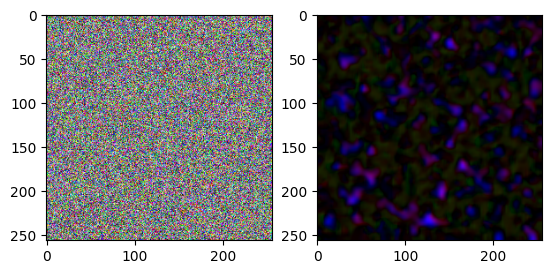

In [101]:
sanity_check(DenoiseAutoEncoder())

### Model Initialization

In [9]:
### Assamble Model
loss_function = F.binary_cross_entropy_with_logits
learning_rate = 0.001

AE = AutoEncoder()
AE.to(device)

optimizer = torch.optim.Adam(AE.parameters(), lr=learning_rate)
print(AE)

AutoEncoder(
  (encoder1): Sequential(
    (0): Conv2d(3, 6, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): InstanceNorm2d(2, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (2): ReLU(inplace=True)
  )
  (encoder2): Sequential(
    (0): Conv2d(6, 6, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): InstanceNorm2d(2, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (2): ReLU(inplace=True)
  )
  (encoder3): Sequential(
    (0): Conv2d(6, 6, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): InstanceNorm2d(2, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (2): ReLU(inplace=True)
  )
  (decoder1): Sequential(
    (0): Upsample(scale_factor=4.0, mode='bilinear')
    (1): ReflectionPad2d((1, 1, 1, 1))
    (2): Conv2d(6, 6, kernel_size=(4, 4), stride=(2, 2))
    (3): InstanceNorm2d(2, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (4): ReLU(inplace=True)
  )
  (decoder2): S

In [108]:
### assemble AE Fully Connected
loss_function = F.binary_cross_entropy_with_logits
learning_rate = 0.001

AEFC = AutoEncoderFC()
AEFC.to(device)

optimizer = torch.optim.Adam(AEFC.parameters(), lr=learning_rate)
print(AEFC)

NameError: ignored

In [109]:
loss_function = F.binary_cross_entropy_with_logits
learning_rate = 0.001

DAE = DenoiseAutoEncoder()
DAE.to(device)

optimizer = torch.optim.Adam(DAE.parameters(), lr=learning_rate)
print(DAE)

PONG
PING
DenoiseAutoEncoder(
  (encoder1): Sequential(
    (0): Conv2d(3, 6, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): InstanceNorm2d(2, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (2): ReLU(inplace=True)
  )
  (encoder2): Sequential(
    (0): Conv2d(6, 6, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): InstanceNorm2d(2, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (2): ReLU(inplace=True)
  )
  (encoder3): Sequential(
    (0): Conv2d(6, 6, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): InstanceNorm2d(2, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (2): ReLU(inplace=True)
  )
  (decoder1): Sequential(
    (0): Upsample(scale_factor=4.0, mode='bilinear')
    (1): ReflectionPad2d((1, 1, 1, 1))
    (2): Conv2d(6, 6, kernel_size=(4, 4), stride=(2, 2))
    (3): InstanceNorm2d(2, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (4): ReLU(inplace=True)
  

### Dataset Loading

In [18]:
def loadDatasetZipFromDrive(link, data_path = "data/",folder = "imgs"):


  # Setup path to data folder
  data_path = Path(data_path)
  image_path = data_path / folder

  # If the image folder doesn't exist, download it and prepare it...
  if image_path.is_dir():
      print(f"{image_path} directory exists.")
  else:
      print(f"Did not find {image_path} directory, creating one...")
      image_path.mkdir(parents=True, exist_ok=True)

      # Download pizza, steak, sushi data
      with open(data_path / (folder + ".zip"), "wb") as f:
          request = requests.get(link)
          print("Downloading dataset...")
          f.write(request.content)

      # Unzip pizza, steak, sushi data
      with zipfile.ZipFile(data_path / (folder + ".zip"), "r") as zip_ref:
          print("Unzipping dataset...")
          zip_ref.extractall(image_path)


  # no labels, since each input image is the desired output

  TRAIN_IMAGE_ROOT = "./" + str(image_path) + "/training/input"
  #TRAIN_LABEL_ROOT = "./data/RETINA/training/target"

  TEST_IMAGE_ROOT = "./" + str(image_path) +"/test/input"
  #TEST_LABEL_ROOT = "./data/RETINA/test/target"

  images = sorted(glob(os.path.join(TRAIN_IMAGE_ROOT, "*training.tif")))
  #labels = sorted(glob(os.path.join(TRAIN_LABEL_ROOT, "*manual1.png")))

  testimages = sorted(glob(os.path.join(TEST_IMAGE_ROOT, "*test.tif")))
  #testlabels = sorted(glob(os.path.join(TEST_LABEL_ROOT, "*manual1.gif")))

  #return images, label, testimages, testlabels
  return images, testimages

Did not find data/imgs directory, creating one...
Unzipping dataset...


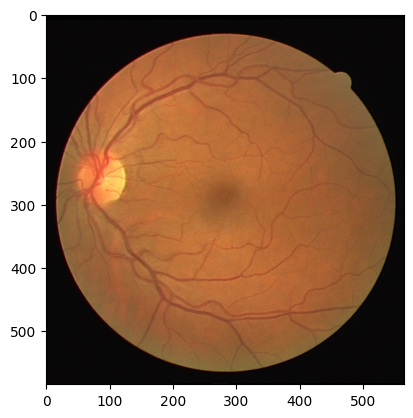

In [19]:
imgs, test = loadDatasetZipFromDrive(link= "https://drive.google.com/u/0/uc?id=10Uy_UT0JgjCTCcirzTGs5_nNDmH_MryX&export=download&confirm=t&uuid=211af45b-bdaa-4f76-aed9-5c786d7173e4&at=AB6BwCALI4ZjjkzYftiUni1t1842:1697461941658")

#check if loading propperly
plt.imshow(Image.open(test[0]))


In [20]:
class DRIVEDataset(Dataset):
    """DRIVE dataset."""

    def __init__(self, image_files, transform=None):
        """

        :param image_files:
        :param label_files:
        :param transform:
        """
        self.image_files = image_files
        self.label_files = image_files
        self.transform = transform

        print("Initialized propperly")

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = self.image_files[idx]
        seg_name = self.label_files[idx]

        image = Image.open(img_name)
        label = Image.open(seg_name)

        if self.transform:
            image = self.transform(image)
            label = self.transform(label)

        sample = {"img": image, "seg": label}

        #return sample
        return image, label

In [21]:
transform = transforms.Compose([
    transforms.Resize((256,256)),
    transforms.ToTensor(),
])

img_transform = transforms.Compose([
    transforms.Resize((256,256)),
    transforms.ToPILImage(),
])

In [22]:
train_ds = DRIVEDataset (imgs, transform=transform)
valid_ds = DRIVEDataset(test, transform=transform)

batchSize = 4

train_loader = DataLoader(
    train_ds, batch_size=batchSize, shuffle=True, num_workers=0, pin_memory=True,
)

test_loader = DataLoader(
    valid_ds, batch_size=batchSize, shuffle=True, num_workers=0, pin_memory=True,
)

Initialized propperly
Initialized propperly


###Training

In [112]:
from torch.utils.tensorboard import SummaryWriter

def trainModel(model, optimizer, num_epochs):
    # start a typical PyTorch training
    epochs_total = num_epochs
    val_interval = 1
    best_loss = np.inf
    best_metric_epoch = -1
    epoch_loss_values = list()
    #metric_values = list()
    writer = SummaryWriter()
    for epoch in range(epochs_total):
        print("-" * 10)
        print(f"epoch {epoch + 1}/{epochs_total}")
        model.train()
        epoch_loss = 0
        step = 0
        for batch_data in train_loader:
            step += 1
            inputs, labels, weights = (
                        #batch_data["img"].to(device),
                        batch_data[0].to(device),
                        #batch_data["seg"].to(device),
                        batch_data[1].to(device),
                        #batch_data["map"].to(device),
                        0,
            )
            optimizer.zero_grad()
            outputs = model(inputs).squeeze()
            loss = loss_function(outputs, labels)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
            epoch_len = len(train_ds) // train_loader.batch_size
            print(f"{step}/{epoch_len}, train_loss: {loss.item():.4f}")
            writer.add_scalar("train_loss", loss.item(), epoch_len * epoch + step)
        epoch_loss /= step
        epoch_loss_values.append(epoch_loss)
        print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

        if (epoch + 1) % val_interval == 0:
            model.eval()
            with torch.no_grad():
                epoch_val_loss = []
                val_images = None
                val_labels = None
                val_outputs = None
                for val_data in test_loader:
                    val_images, val_labels, val_weights = (
                        #val_data["img"].to(device),
                        val_data[0].to(device),
                        #val_data["seg"].to(device),
                        val_data[1].to(device),
                        #val_data["map"].to(device),
                        0,
                    )
                    val_outputs = model(val_images).squeeze()
                    loss = loss_function(val_outputs, val_labels)
                    epoch_val_loss.append(loss.item())
                epoch_val_loss = np.array(epoch_val_loss).mean()
                if epoch_val_loss < best_loss:
                    best_loss = epoch_val_loss
                    best_metric_epoch = epoch + 1
                    torch.save(
                        model.state_dict(), "best_metric_model_segmentation2d_dict.pth"
                    )
                    print("saved new best metric model")
                print(
                    "current epoch: {} current val loss: {:.4f} best val loss: {:.4f} at epoch {}".format(
                        epoch + 1, epoch_val_loss, best_loss, best_metric_epoch
                    )
                )
                writer.add_scalar("val_loss", epoch_val_loss, epoch + 1)
                # plot the last model output as GIF image in TensorBoard with the corresponding image and label
                #plot_2d_or_3d_image(val_images, epoch + 1, writer, index=0, tag="image")
                #plot_2d_or_3d_image(val_labels, epoch + 1, writer, index=0, tag="label")
                #plot_2d_or_3d_image(
                #    val_outputs, epoch + 1, writer, index=0, tag="output"
                #)

    print(f"train completed, best_loss: {best_loss:.4f} at epoch: {best_metric_epoch}")
    writer.close()
    return epoch_loss_values




### Run Training

In [34]:
losses = trainModel(AE, optimizer,50)

----------
epoch 1/50
1/5, train_loss: 0.6898


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/instancenorm.py:80: UserWarning: input's size at dim=1 does not match num_features. You can silence this warning by not passing in num_features, which is not used because affine=False
  warnings.warn(f"input's size at dim={feature_dim} does not match num_features. "


2/5, train_loss: 0.6673
3/5, train_loss: 0.6527
4/5, train_loss: 0.6371
5/5, train_loss: 0.6240
epoch 1 average loss: 0.6542
saved new best metric model
current epoch: 1 current val loss: 0.6115 best val loss: 0.6115 at epoch 1
----------
epoch 2/50
1/5, train_loss: 0.6120
2/5, train_loss: 0.5980
3/5, train_loss: 0.5872
4/5, train_loss: 0.5785
5/5, train_loss: 0.5648
epoch 2 average loss: 0.5881
saved new best metric model
current epoch: 2 current val loss: 0.5546 best val loss: 0.5546 at epoch 2
----------
epoch 3/50
1/5, train_loss: 0.5563
2/5, train_loss: 0.5451
3/5, train_loss: 0.5388
4/5, train_loss: 0.5335
5/5, train_loss: 0.5297
epoch 3 average loss: 0.5407
saved new best metric model
current epoch: 3 current val loss: 0.5200 best val loss: 0.5200 at epoch 3
----------
epoch 4/50
1/5, train_loss: 0.5186
2/5, train_loss: 0.5201
3/5, train_loss: 0.5086
4/5, train_loss: 0.5092
5/5, train_loss: 0.5002
epoch 4 average loss: 0.5113
saved new best metric model
current epoch: 4 current 

In [19]:
losses = trainModel(AEFC, optimizer,50)

----------
epoch 1/50
1/5, train_loss: 0.8179
2/5, train_loss: 0.8158
3/5, train_loss: 0.8099
4/5, train_loss: 0.7695
5/5, train_loss: 0.7485
epoch 1 average loss: 0.7923
saved new best metric model
current epoch: 1 current val loss: 0.7278 best val loss: 0.7278 at epoch 1
----------
epoch 2/50
1/5, train_loss: 0.7129
2/5, train_loss: 0.7283
3/5, train_loss: 0.7052
4/5, train_loss: 0.7247
5/5, train_loss: 0.6815
epoch 2 average loss: 0.7105
saved new best metric model
current epoch: 2 current val loss: 0.6882 best val loss: 0.6882 at epoch 2
----------
epoch 3/50
1/5, train_loss: 0.6932
2/5, train_loss: 0.6871
3/5, train_loss: 0.6956
4/5, train_loss: 0.6902
5/5, train_loss: 0.6800
epoch 3 average loss: 0.6892
saved new best metric model
current epoch: 3 current val loss: 0.6810 best val loss: 0.6810 at epoch 3
----------
epoch 4/50
1/5, train_loss: 0.6913
2/5, train_loss: 0.6911
3/5, train_loss: 0.6835
4/5, train_loss: 0.6799
5/5, train_loss: 0.6761
epoch 4 average loss: 0.6844
saved n

In [113]:
losses = trainModel(DAE, optimizer,50)

----------
epoch 1/50


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/instancenorm.py:80: UserWarning: input's size at dim=1 does not match num_features. You can silence this warning by not passing in num_features, which is not used because affine=False
  warnings.warn(f"input's size at dim={feature_dim} does not match num_features. "


1/5, train_loss: 0.7090
2/5, train_loss: 0.6965
3/5, train_loss: 0.6832
4/5, train_loss: 0.6771
5/5, train_loss: 0.6625
epoch 1 average loss: 0.6857
saved new best metric model
current epoch: 1 current val loss: 0.6478 best val loss: 0.6478 at epoch 1
----------
epoch 2/50
1/5, train_loss: 0.6492
2/5, train_loss: 0.6404
3/5, train_loss: 0.6261
4/5, train_loss: 0.6124
5/5, train_loss: 0.5997
epoch 2 average loss: 0.6255
saved new best metric model
current epoch: 2 current val loss: 0.5897 best val loss: 0.5897 at epoch 2
----------
epoch 3/50
1/5, train_loss: 0.5896
2/5, train_loss: 0.5798
3/5, train_loss: 0.5727
4/5, train_loss: 0.5612
5/5, train_loss: 0.5597
epoch 3 average loss: 0.5726
saved new best metric model
current epoch: 3 current val loss: 0.5433 best val loss: 0.5433 at epoch 3
----------
epoch 4/50
1/5, train_loss: 0.5507
2/5, train_loss: 0.5378
3/5, train_loss: 0.5291
4/5, train_loss: 0.5279
5/5, train_loss: 0.5159
epoch 4 average loss: 0.5323
saved new best metric model
c

### Usage

### Visualization


torch.Size([1, 3, 256, 256])


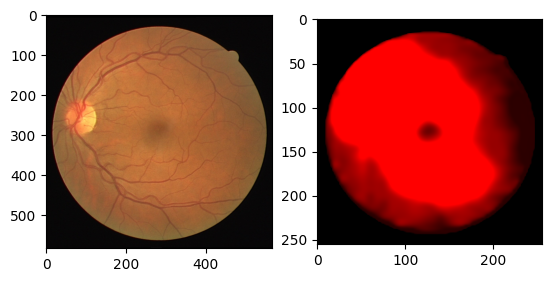

In [35]:
test_img = Image.open(test[0])

with torch.no_grad():
  outputs = AE(transform(test_img).unsqueeze(0).to(device))
  print(outputs.shape)

f, axarr = plt.subplots(1,2)

#the 0th image of the 'batch', changing channels to match the right order.
axarr[0].imshow(test_img)
axarr[1].imshow(outputs[0].cpu().detach().permute(1, 2, 0), cmap="gray")

torch.Size([1, 3, 256, 256])


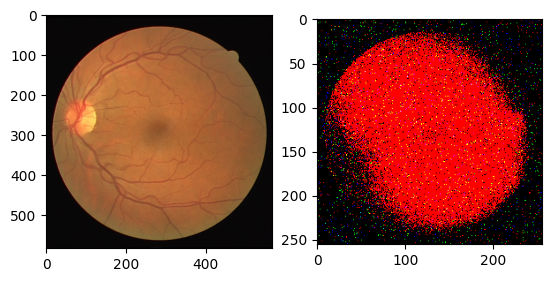

In [20]:
test_img = Image.open(test[0])

with torch.no_grad():
  outputs = AEFC(transform(test_img).unsqueeze(0).to(device))
  print(outputs.shape)

f, axarr = plt.subplots(1,2)

#the 0th image of the 'batch', changing channels to match the right order.
axarr[0].imshow(test_img)
axarr[1].imshow(outputs[0].cpu().detach().permute(1, 2, 0), cmap="gray")

torch.Size([1, 3, 256, 256])


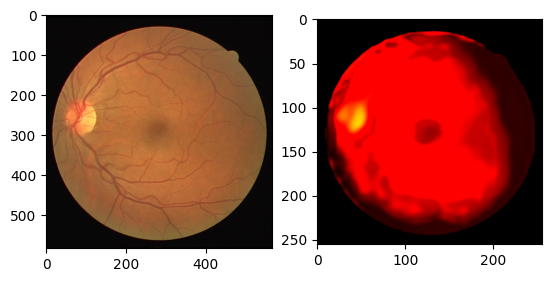

In [114]:
test_img = Image.open(test[0])

with torch.no_grad():
  outputs = DAE(transform(test_img).unsqueeze(0).to(device))
  print(outputs.shape)

f, axarr = plt.subplots(1,2)

#the 0th image of the 'batch', changing channels to match the right order.
axarr[0].imshow(test_img)
axarr[1].imshow(outputs[0].cpu().detach().permute(1, 2, 0), cmap="gray")